### Importing Necessary Libraries

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import lit, col, count, avg, min, max
from pyspark.sql.types import ArrayType, StringType, StructType, StructField
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score


### Loading Data

##### Creating spark Session to load data stored on local disk

##### Pneumonia data is downloaded from https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
##### Covid data is downloaded from https://www.kaggle.com/datasets/andyczhao/covidx-cxr2/code

In [3]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Covid-19 and Pneumonia detection using CNN") \
    .getOrCreate()

24/05/05 14:35:25 WARN Utils: Your hostname, Ramyas-Laptop.local resolves to a loopback address: 127.0.0.1; using 192.0.0.2 instead (on interface en0)
24/05/05 14:35:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/05 14:35:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
SparkSession.builder.getOrCreate()

### Define Data Directories and Read Images using Spark

In [5]:
# Define the data directories - path where data is stored
DataDir = "/Users/ramyasritellakula/Documents/Covid_19_detection/covid"

# Read images from the directories using the "image" format
data_df = spark.read.format("image").load(DataDir)

# Show the schema and the first few rows of the dataframes
print("COVID-19 Dataset Schema:")
data_df.printSchema()


24/05/05 14:35:36 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


COVID-19 Dataset Schema:
root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [6]:
# Define the data directories
PneumoniaDir = "/Users/ramyasritellakula/Documents/Covid_19_detection/chest_xray"

# Read images from the directories using the "image" format
pneumonia_df = spark.read.format("image").load(PneumoniaDir)

# Show the schema and the first few rows of the dataframes
print("Pneumonia Dataset Schema:")
pneumonia_df.printSchema()

Pneumonia Dataset Schema:
root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



##### List of Directories and Their Contents of Covid and Pneumonia Datasets

In [7]:
# Define a UDF to list directories
@udf(returnType=ArrayType(StringType()))
def list_directories(directory):
    return os.listdir(directory)

# Create a DataFrame with the directories
directories_df = spark.createDataFrame([(DataDir,), (PneumoniaDir,)], ["Directory"])

# Apply the UDF to list directories
directories_with_files_df = directories_df.withColumn("Files", list_directories("Directory"))

# Show the directories and their contents
directories_with_files_df.show(truncate=False)


+----------------------------------------------------------------+-----------------------------------------------------------+
|Directory                                                       |Files                                                      |
+----------------------------------------------------------------+-----------------------------------------------------------+
|/Users/ramyasritellakula/Documents/Covid_19_detection/covid     |[.DS_Store, test, train.txt, train, test.txt, val.txt, val]|
|/Users/ramyasritellakula/Documents/Covid_19_detection/chest_xray|[.DS_Store, test, __MACOSX, train, val]                    |
+----------------------------------------------------------------+-----------------------------------------------------------+



### Pneumonia Data Preparation

In [8]:
#Paths to the data directories
train_image_dir = PneumoniaDir + '/train'
test_image_dir = PneumoniaDir + '/test'
val_image_dir = PneumoniaDir + '/val'

# Schema for the Spark DataFrame
schema = StructType([
    StructField("image_path", StringType(), True),
    StructField("label", StringType(), True)
])

# Function to prepare data from a directory and return a Spark DataFrame
def prepare_data_spark(image_dir, strat):
    
    # List of categories in the dataset
    categories = ["NORMAL", "PNEUMONIA"]
    
    # Initialize an empty list to store data
    data = []
    
    # Iterate through each category and process images
    for category in categories:
        category_path = os.path.join(image_dir, category)
        
        # Iterate through each image file in the category
        for img_file in tqdm(os.listdir(category_path)):
            img_path = os.path.join(category_path, img_file)
            
            # Append a tuple with the image path and label
            data.append((img_path, category))
    
    # Create a Spark DataFrame from the list of data tuples
    df = spark.createDataFrame(data, schema=schema)
    # Add a column for the strategy (e.g., train, test, val)
    df = df.withColumn("strategy", lit(strat))
    
    return df

# Prepare data for train, test, and validation sets using Spark
train_df = prepare_data_spark(train_image_dir, 'train')
test_df = prepare_data_spark(test_image_dir, 'test')
val_df = prepare_data_spark(val_image_dir, 'val')

100%|█████████████████████████████████████████| 8/8 [00:00<00:00, 360800.34it/s]


In [9]:
# Combine the data frames for train, test, and validation sets
pneumonia_data_df = train_df.unionByName(test_df).unionByName(val_df)

# Shuffle the combined DataFrame
pneumonia_data_df1 = pneumonia_data_df.orderBy('strategy')

In [10]:
# Save the pneumonia DataFrame to a specified CSV file
pneumonia_csv_path = "/Users/ramyasritellakula/Documents/Covid_19_detection/result/pneumonia_data.csv" 

pneumonia_data_df1.write.csv(pneumonia_csv_path, header=True, mode='overwrite')

### Covid-19 Data Preparation

In [11]:
# Schema for the Spark DataFrame
schema = StructType([
    StructField("image_id", StringType(), True),
    StructField("image_path", StringType(), True),
    StructField("label", StringType(), True)
])

# Image data directory and file paths

train_txt_path = os.path.join(DataDir, "train.txt")
test_txt_path = os.path.join(DataDir, "test.txt")
val_txt_path = os.path.join(DataDir, "val.txt")

# Function to classify label
def classify_label(label):
    if label == "negative":
        return "NORMAL"
    elif label == "positive":
        return "COVID"
    else:
        return None  

# Function to process text file and create a Spark DataFrame
def process_txt_to_df(txt_path, strat):
    
    # Read the text file as an RDD
    rdd = spark.read.text(txt_path).rdd
    
    # Process each line in the RDD
    def process_line(line):
        querywords = line[0].split()  # Line is a tuple, extract the text
        image_id = querywords[0]
        img_formats = ['jpg', 'jpeg', 'png']
        
        # Determine the image path and label based on the line length
        if len(querywords) == 4:
            image_path = os.path.join(DataDir, strat, querywords[1])
            label = querywords[2]
        elif len(querywords) == 5:
            image_path = os.path.join(DataDir, strat, querywords[2])
            label = querywords[3]
        else:
            return None
        
        # Check the image format
        for img_format in img_formats:
            if img_format in image_path:
                # Classify label
                classified_label = classify_label(label)
                if classified_label:
                    return (image_id, image_path, classified_label)
        
        return None
    
    # Map and filter RDD
    processed_rdd = rdd.map(process_line).filter(lambda x: x is not None)
    
    # Convert RDD to DataFrame
    df = spark.createDataFrame(processed_rdd, schema=schema)
    
    # Add strategy column
    df = df.withColumn("strategy", lit(strat))
    
    return df

# Process train, test, and validation text files
train_df = process_txt_to_df(train_txt_path, "train")
test_df = process_txt_to_df(test_txt_path, "test")
val_df = process_txt_to_df(val_txt_path, "val")

In [12]:
# Combine the data frames
covid_data_df = train_df.unionByName(test_df).unionByName(val_df)

# Drop the image_id column - dropped image_id column to equate the no.of columns in both datasets
covid_data_df1 = covid_data_df.drop("image_id")

In [13]:
# Save the combined DataFrame to a CSV file
covid_csv_path = "/Users/ramyasritellakula/Documents/Covid_19_detection/result/covid_data.csv"  

covid_data_df1.write.csv(covid_csv_path, header=True, mode="overwrite")

### Representing Pneumonia and COVID-19 datasets into a single spark DataFrame

In [14]:

# Load the CSV files as DataFrames
df_pneumonia = spark.read.csv(pneumonia_csv_path, header=True, inferSchema=True)
df_covid = spark.read.csv(covid_csv_path, header=True, inferSchema=True)


In [15]:
# Combine the two DataFrames using unionByName()
combined_data_df = df_pneumonia.unionByName(df_covid)

# shuffle the combined DataFrame based on the strategy
combined_data_df1 = combined_data_df.orderBy("strategy").sample(withReplacement=False, fraction=1.0, seed=42)


In [16]:
# Path to save the combined CSV file
combined_data_path = "/Users/ramyasritellakula/Documents/Covid_19_detection/result/complete_data.csv"  # Update with your desired output path

# Save the combined DataFrame as a CSV file
combined_data_df1.write.csv(combined_data_path, header=True, mode='overwrite')


### Visualization -Displaying Images Using Spark DataFrame

In [17]:
# Function to display images using Spark DataFrame
def print_images_spark(samples_df):
    
    # Convert PySpark DataFrame to Pandas DataFrame
    samples_pd = samples_df.toPandas()
    
    # Get image paths and labels as NumPy arrays
    images = samples_pd["image_path"].to_numpy()
    labels = samples_pd["label"].to_numpy()
    
    # Set up the figure
    fig = plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1
    
    # Display images
    for i, image_path in enumerate(images):
        # Read the image using OpenCV
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        # Add a subplot for each image
        fig.add_subplot(rows, columns, i + 1)
        
        # Resize the image for better visualization
        resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)
        
        # Display the image
        plt.imshow(resized_image, cmap='gray')
        # Set the title to the corresponding label
        plt.title(labels[i])
    
    # Show the plot
    plt.show()


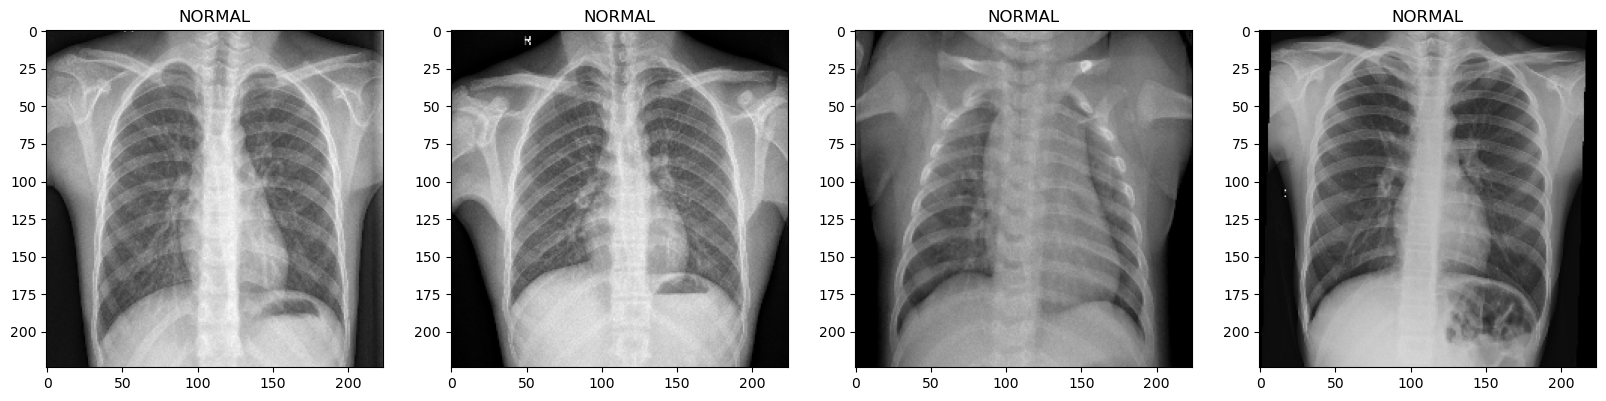

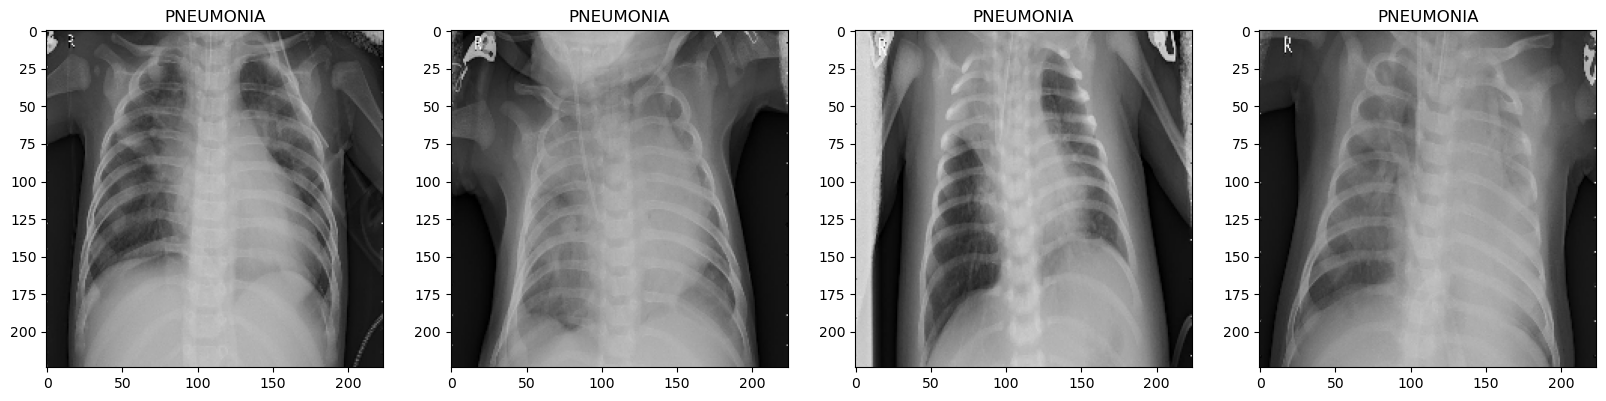

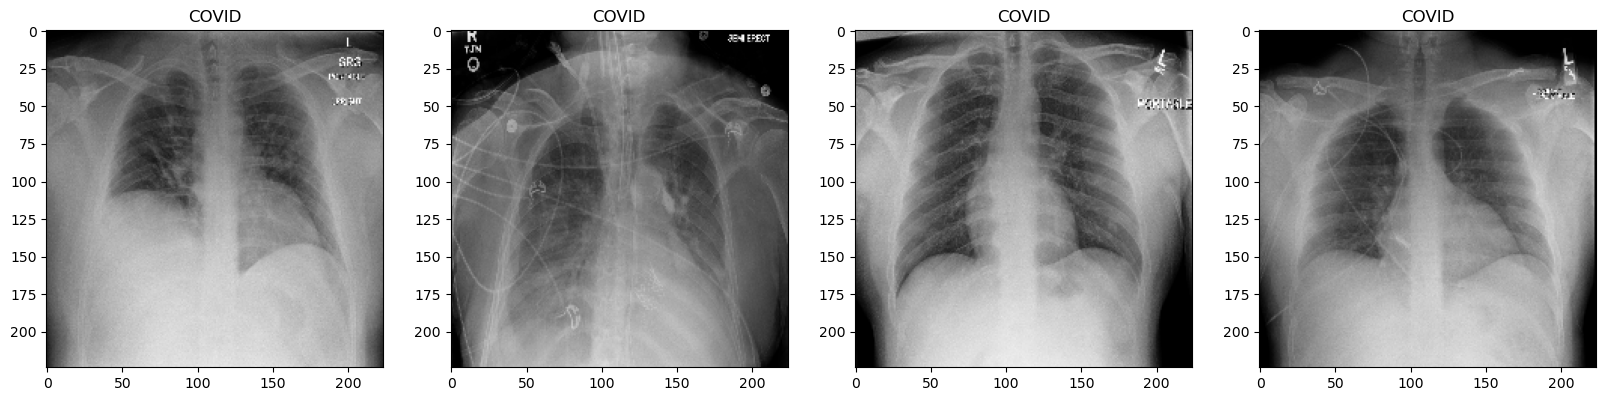

In [18]:
# Load the data from the CSV file 
# Filter samples with different labels and display images

print_images_spark(combined_data_df1.filter(col("label") == "NORMAL").limit(4))
print_images_spark(combined_data_df1.filter(col("label") == "PNEUMONIA").limit(4))
print_images_spark(combined_data_df1.filter(col("label") == "COVID").limit(4))

### Exploratory Data Analysis (EDA)

##### 1. Data Overview - Prints the schema and shows a sample of the data.

In [19]:
# Print Data Schema
print("Data Schema:")
combined_data_df1.printSchema()

Data Schema:
root
 |-- image_path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- strategy: string (nullable = true)



In [20]:
# Print Data Sample (Top 5 rows)
print("\nData Sample (Top 5 rows):")
combined_data_df1.show(5)


Data Sample (Top 5 rows):
+--------------------+------+--------+
|          image_path| label|strategy|
+--------------------+------+--------+
|/Users/ramyasrite...|NORMAL|    test|
|/Users/ramyasrite...|NORMAL|    test|
|/Users/ramyasrite...|NORMAL|    test|
|/Users/ramyasrite...|NORMAL|    test|
|/Users/ramyasrite...|NORMAL|    test|
+--------------------+------+--------+
only showing top 5 rows



In [21]:
# Print Data Sample (Random 5 rows)
print("\nData Sample (Random 5 rows):")
combined_data_df1.sample(fraction=0.01, seed=42).show(5)


Data Sample (Random 5 rows):
+--------------------+---------+--------+
|          image_path|    label|strategy|
+--------------------+---------+--------+
|/Users/ramyasrite...|PNEUMONIA|    test|
|/Users/ramyasrite...|PNEUMONIA|    test|
|/Users/ramyasrite...|PNEUMONIA|    test|
|/Users/ramyasrite...|    COVID|    test|
|/Users/ramyasrite...|    COVID|    test|
+--------------------+---------+--------+
only showing top 5 rows



##### 2. Class Distribution: Calculates and visualizes the distribution of classes in the dataset.

In [22]:
# Class Distribution
class_distribution = combined_data_df1.groupBy("label").count()
print("\nClass Distribution:")
class_distribution.show()


Class Distribution:
+---------+-----+
|    label|count|
+---------+-----+
|    COVID|65681|
|PNEUMONIA| 4274|
|   NORMAL|20718|
+---------+-----+



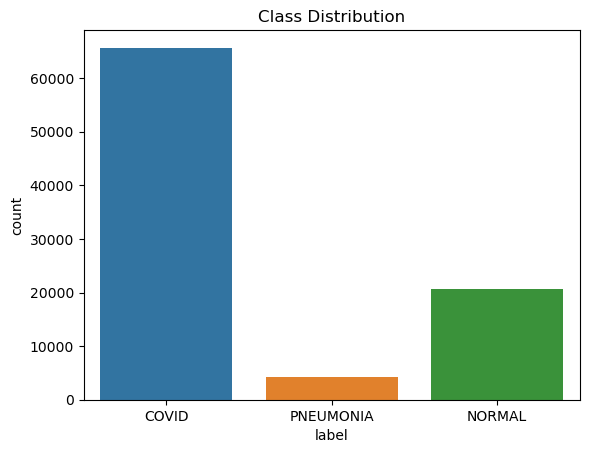

In [23]:
# Convert class distribution to Pandas DataFrame for plotting
class_distribution_pd = class_distribution.toPandas()

# Plot class distribution
sns.barplot(x="label", y="count", data=class_distribution_pd)
plt.title("Class Distribution")
plt.show()

### Cleaning Image Data

In [24]:
# Load the combined data
combined_data_df1 = spark.read.csv("/Users/ramyasritellakula/Documents/Covid_19_detection/result/complete_data.csv",
                             header=True, inferSchema=True)


In [25]:
# Step 1: Remove rows with missing values in important columns
cleaned_df = combined_data_df1.dropna(subset=['image_path', 'label'])

# Step 2: Remove duplicate rows based on image path
cleaned_df = cleaned_df.dropDuplicates(['image_path'])


In [26]:
# Step 3: Verify image paths
# Convert the DataFrame to an RDD and filter out rows with invalid paths
def is_valid_image_path(row):
    image_path = row.image_path
    try:
        # Attempt to open the image
        with Image.open(image_path):
            return True
    except:
        # Image could not be opened or path is invalid
        return False

valid_images_rdd = cleaned_df.rdd.filter(is_valid_image_path)

# Convert the RDD back to a DataFrame
cleaned_df = spark.createDataFrame(valid_images_rdd, schema=combined_data_df1.schema)

In [27]:
# Step 4: Verify labels
# Ensure that the labels are within the expected range ('NORMAL', 'PNEUMONIA', 'COVID')
expected_labels = ['NORMAL', 'PNEUMONIA', 'COVID']
cleaned_df = cleaned_df.filter(cleaned_df['label'].isin(expected_labels))

In [28]:
# Step 5: Save the cleaned data to a new CSV file
cleaned_output_path = "/Users/ramyasritellakula/Documents/Covid_19_detection/result/cleaned_data.csv"
cleaned_df.write.csv(cleaned_output_path, header=True, mode='overwrite')

In [29]:
# Calculate the count of rows in the cleaned data
cleaned_count = cleaned_df.count()

# Print the count of rows in the cleaned data
print("After cleaning, data has {} rows ".format(cleaned_count))


After cleaning, data has 87594 rows 


### Data Splitting, Analysis and Building Model

### SET1 - 2000 images

##### 1. Data Splitting and Training Model using CNN of SET1 images

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("Covid19Detection").getOrCreate()
# Load the data into a Spark DataFrame
combined_df = spark.read.csv("/Users/ramyasritellakula/Documents/Covid_19_detection/result/cleaned_data.csv", header=True, inferSchema=True)

# Convert Spark DataFrame to Pandas DataFrame
combined_df_pandas = combined_df.toPandas()

# Split data into features (image paths) and labels
X = combined_df_pandas['image_path']
y = combined_df_pandas['label']

# Sample train data to get exactly 2000 samples
train_sample_size = 2000
train_data = combined_df_pandas.sample(n=train_sample_size, random_state=42)
X_train = train_data['image_path']
y_train = train_data['label']

# Get remaining data for test and validation
remaining_data = combined_df_pandas.drop(train_data.index)

# Split remaining data into test and validation sets (80% test, 20% validation)
X_remaining = remaining_data['image_path']
y_remaining = remaining_data['label']
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.2, random_state=42)

# Print the sizes and label counts
print(f"Size of training set: {len(X_train)} samples")
print(f"Size of validation set: {len(X_val)} samples")
print(f"Size of test set: {len(X_test)} samples")

print("\nLabel counts in training set:")
print(y_train.value_counts())

print("\nLabel counts in validation set:")
print(y_val.value_counts())

print("\nLabel counts in test set:")
print(y_test.value_counts())


# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Create image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for train, test, and validation sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_train, 'label': y_train}),
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_val, 'label': y_val}),
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_test, 'label': y_test}),
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define model checkpoint to save best model during training
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


24/05/05 05:13:55 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Size of training set: 2000 samples
Size of validation set: 17119 samples
Size of test set: 68475 samples

Label counts in training set:
label
COVID        1441
NORMAL        461
PNEUMONIA      98
Name: count, dtype: int64

Label counts in validation set:
label
COVID        12243
NORMAL        4025
PNEUMONIA      851
Name: count, dtype: int64

Label counts in test set:
label
COVID        49176
NORMAL       15975
PNEUMONIA     3324
Name: count, dtype: int64
Found 2000 validated image filenames belonging to 3 classes.
Found 17119 validated image filenames belonging to 3 classes.
Found 68475 validated image filenames belonging to 3 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.6485 - loss: 0.8995
Epoch 1: val_accuracy improved from -inf to 0.73531, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 1167s 19s/step - accuracy: 0.6493 - loss: 0.8971 - val_accuracy: 0.7353 - val_loss: 0.5994
Epoch 2/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 25s 416ms/step - accuracy: 0.7812 - loss: 0.5575
Epoch 2: val_accuracy improved from 0.73531 to 0.80645, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7812 - loss: 0.5575 - val_accuracy: 0.8065 - val_loss: 0.5457
Epoch 3/10


2024-05-05 05:33:25.045496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-05 05:33:25.167325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7519 - loss: 0.5852
Epoch 3: val_accuracy did not improve from 0.80645
62/62 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7518 - loss: 0.5852 - val_accuracy: 0.7672 - val_loss: 0.5664
Epoch 4/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 25s 417ms/step - accuracy: 0.8750 - loss: 0.4702
Epoch 4: val_accuracy did not improve from 0.80645
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.4702 - val_accuracy: 0.7419 - val_loss: 0.5754
Epoch 5/10


2024-05-05 05:35:39.014144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 05:35:39.135186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7701 - loss: 0.5471 
Epoch 5: val_accuracy did not improve from 0.80645
62/62 ━━━━━━━━━━━━━━━━━━━━ 746s 12s/step - accuracy: 0.7703 - loss: 0.5468 - val_accuracy: 0.8010 - val_loss: 0.5504
Epoch 6/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 25s 423ms/step - accuracy: 0.8438 - loss: 0.5356
Epoch 6: val_accuracy did not improve from 0.80645
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.5356 - val_accuracy: 0.7419 - val_loss: 0.7803
Epoch 7/10


2024-05-05 05:48:06.034765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 05:48:06.157397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 42s/step - accuracy: 0.8021 - loss: 0.4691 
Epoch 7: val_accuracy improved from 0.80645 to 0.82362, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 2646s 43s/step - accuracy: 0.8023 - loss: 0.4690 - val_accuracy: 0.8236 - val_loss: 0.4497
Epoch 8/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 24s 409ms/step - accuracy: 0.8125 - loss: 0.3515
Epoch 8: val_accuracy did not improve from 0.82362
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.3515 - val_accuracy: 0.6774 - val_loss: 0.7192
Epoch 9/10


2024-05-05 06:32:12.722971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 06:32:12.840504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8516 - loss: 0.4009
Epoch 9: val_accuracy improved from 0.82362 to 0.83772, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 4484s 73s/step - accuracy: 0.8516 - loss: 0.4006 - val_accuracy: 0.8377 - val_loss: 0.4135
Epoch 10/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 24s 402ms/step - accuracy: 0.8125 - loss: 0.3802
Epoch 10: val_accuracy improved from 0.83772 to 0.90323, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.3802 - val_accuracy: 0.9032 - val_loss: 0.3167


2024-05-05 07:46:57.157449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 07:46:57.271002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2140/2140 ━━━━━━━━━━━━━━━━━━━━ 3196s 1s/step - accuracy: 0.8322 - loss: 0.4226
Test Loss: 0.4207819998264313
Test Accuracy: 0.833734929561615


##### 2. Accuracy and Loss Graphs for SET1 images

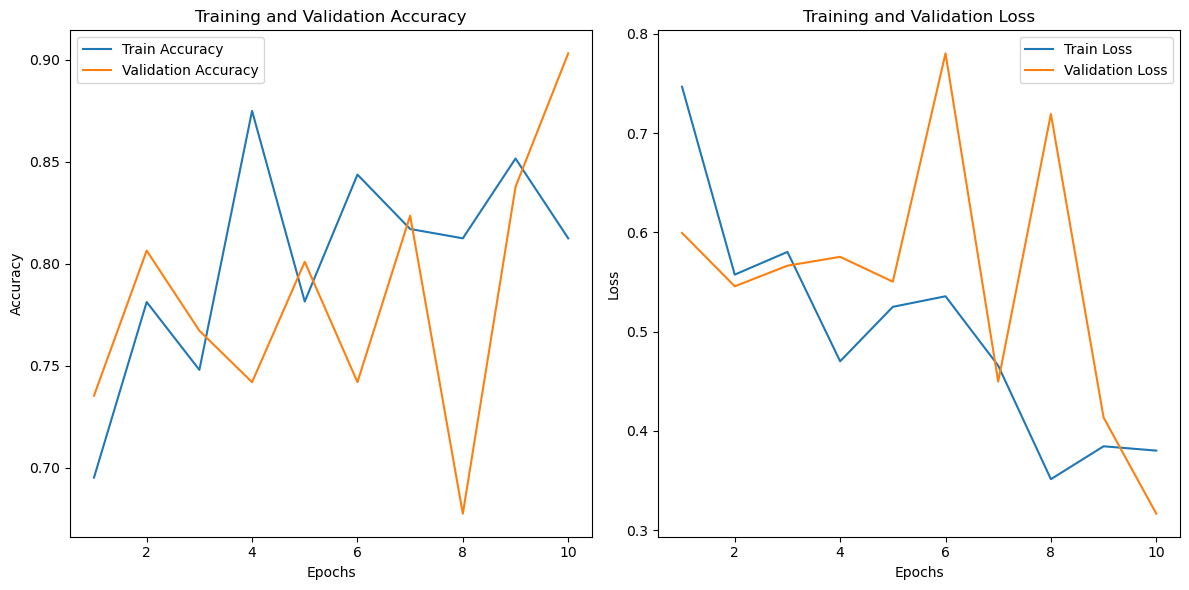

In [31]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Plotting training and validation accuracy
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)  # Create subplot for accuracy
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # Create subplot for loss
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a history object from model training
plot_accuracy_and_loss(history)


##### 3. Model Evaluation for SET1 images

In [32]:
from sklearn.metrics import classification_report
import numpy as np

def generate_classification_report(model, test_generator):
    
    # Reset the test generator
    test_generator.reset()
    
    # Make predictions on the test set using the model
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices
    
    # Get true labels from the test generator
    y_true = test_generator.classes  # Ground truth labels (class indices)
    
    # Get the class indices mapping from the test generator
    class_indices = test_generator.class_indices
    label_map = {v: k for k, v in class_indices.items()}
    
    # Map class indices back to the original labels
    y_true_labels = [label_map[idx] for idx in y_true]
    y_pred_labels = [label_map[idx] for idx in y_pred]
    
    # Generate and print the classification report
    report = classification_report(y_true_labels, y_pred_labels)
    print("Classification Report:\n", report)
    
    return report

# Generate classification report for the test set predictions
generate_classification_report(model, test_generator)


2140/2140 ━━━━━━━━━━━━━━━━━━━━ 438s 204ms/step
Classification Report:
               precision    recall  f1-score   support

       COVID       0.72      0.77      0.74     49176
      NORMAL       0.23      0.18      0.20     15975
   PNEUMONIA       0.04      0.04      0.04      3324

    accuracy                           0.60     68475
   macro avg       0.33      0.33      0.33     68475
weighted avg       0.57      0.60      0.58     68475



'              precision    recall  f1-score   support\n\n       COVID       0.72      0.77      0.74     49176\n      NORMAL       0.23      0.18      0.20     15975\n   PNEUMONIA       0.04      0.04      0.04      3324\n\n    accuracy                           0.60     68475\n   macro avg       0.33      0.33      0.33     68475\nweighted avg       0.57      0.60      0.58     68475\n'

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, test_generator):
    
    # Reset the test generator
    test_generator.reset()
    
    # Make predictions on the test set using the model
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices
    
    # Get true labels from the test generator
    y_true = test_generator.classes  # Ground truth labels (class indices)
    
    # Get the class indices mapping from the test generator
    class_indices = test_generator.class_indices
    label_map = {v: k for k, v in class_indices.items()}
    
    # Map class indices back to the original labels
    y_true_labels = [label_map[idx] for idx in y_true]
    y_pred_labels = [label_map[idx] for idx in y_pred]
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    print(cm)

# Plot confusion matrix for the test set predictions
plot_confusion_matrix(model, test_generator)


2140/2140 ━━━━━━━━━━━━━━━━━━━━ 452s 211ms/step
[[37989  8879  2308]
 [12306  2865   804]
 [ 2562   620   142]]


### SET2 - 5000 images

##### 1. Data Splitting and Training Model using CNN of SET2 images

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("Covid19Detection").getOrCreate()
# Load the data into a Spark DataFrame
combined_df = spark.read.csv("/Users/ramyasritellakula/Documents/Covid_19_detection/result/cleaned_data.csv", header=True, inferSchema=True)

# Convert Spark DataFrame to Pandas DataFrame
combined_df_pandas = combined_df.toPandas()

# Split data into features (image paths) and labels
X = combined_df_pandas['image_path']
y = combined_df_pandas['label']

# Sample train data to get exactly 5000 samples
train_sample_size = 5000
train_data = combined_df_pandas.sample(n=train_sample_size, random_state=42)
X_train = train_data['image_path']
y_train = train_data['label']

# Get remaining data for test and validation
remaining_data = combined_df_pandas.drop(train_data.index)

# Split remaining data into test and validation sets (80% test, 20% validation)
X_remaining = remaining_data['image_path']
y_remaining = remaining_data['label']
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.2, random_state=42)

# Print the sizes and label counts
print(f"Size of training set: {len(X_train)} samples")
print(f"Size of validation set: {len(X_val)} samples")
print(f"Size of test set: {len(X_test)} samples")

print("\nLabel counts in training set:")
print(y_train.value_counts())

print("\nLabel counts in validation set:")
print(y_val.value_counts())

print("\nLabel counts in test set:")
print(y_test.value_counts())


# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Create image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for train, test, and validation sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_train, 'label': y_train}),
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_val, 'label': y_val}),
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_test, 'label': y_test}),
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define model checkpoint to save best model during training
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Size of training set: 5000 samples
Size of validation set: 16519 samples
Size of test set: 66075 samples

Label counts in training set:
label
COVID        3596
NORMAL       1150
PNEUMONIA     254
Name: count, dtype: int64

Label counts in validation set:
label
COVID        11885
NORMAL        3842
PNEUMONIA      792
Name: count, dtype: int64

Label counts in test set:
label
COVID        47379
NORMAL       15469
PNEUMONIA     3227
Name: count, dtype: int64
Found 5000 validated image filenames belonging to 3 classes.
Found 16519 validated image filenames belonging to 3 classes.
Found 66075 validated image filenames belonging to 3 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.7121 - loss: 0.7352
Epoch 1: val_accuracy improved from -inf to 0.76375, saving model to best_model.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.7123 - loss: 0.7346 - val_accuracy: 0.7637 - val_loss: 0.5598
Epoch 2/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 1:06 428ms/step - accuracy: 0.8125 - loss: 0.3963
Epoch 2: val_accuracy improved from 0.76375 to 0.85714, saving model to best_model.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.8125 - loss: 0.3963 - val_accuracy: 0.8571 - val_loss: 0.4096
Epoch 3/10


2024-05-05 09:10:14.092408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-05 09:10:14.127454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.7976 - loss: 0.5012
Epoch 3: val_accuracy did not improve from 0.85714
156/156 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7976 - loss: 0.5011 - val_accuracy: 0.8353 - val_loss: 0.4017
Epoch 4/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 1:10 452ms/step - accuracy: 0.8125 - loss: 0.4868
Epoch 4: val_accuracy did not improve from 0.85714
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - accuracy: 0.8125 - loss: 0.4868 - val_accuracy: 0.7143 - val_loss: 0.8868
Epoch 5/10


2024-05-05 09:13:22.263271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 09:13:22.298981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8419 - loss: 0.3964
Epoch 5: val_accuracy improved from 0.85714 to 0.85919, saving model to best_model.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.8420 - loss: 0.3964 - val_accuracy: 0.8592 - val_loss: 0.3633
Epoch 6/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 1:08 440ms/step - accuracy: 0.8125 - loss: 0.5037
Epoch 6: val_accuracy did not improve from 0.85919
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - accuracy: 0.8125 - loss: 0.5037 - val_accuracy: 0.5714 - val_loss: 0.5368
Epoch 7/10


2024-05-05 09:16:31.652318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 09:16:31.687489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8665 - loss: 0.3571
Epoch 7: val_accuracy improved from 0.85919 to 0.86592, saving model to best_model.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.8665 - loss: 0.3571 - val_accuracy: 0.8659 - val_loss: 0.3524
Epoch 8/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 1:09 448ms/step - accuracy: 0.9062 - loss: 0.3549
Epoch 8: val_accuracy did not improve from 0.86592
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - accuracy: 0.9062 - loss: 0.3549 - val_accuracy: 0.8571 - val_loss: 0.1651
Epoch 9/10


2024-05-05 09:19:42.244631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 09:19:42.281511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8932 - loss: 0.2935
Epoch 9: val_accuracy improved from 0.86592 to 0.87458, saving model to best_model.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8932 - loss: 0.2935 - val_accuracy: 0.8746 - val_loss: 0.3413
Epoch 10/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 1:17 499ms/step - accuracy: 0.8750 - loss: 0.4025
Epoch 10: val_accuracy improved from 0.87458 to 1.00000, saving model to best_model.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.8750 - loss: 0.4025 - val_accuracy: 1.0000 - val_loss: 0.0461


2024-05-05 09:23:00.972529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 09:23:01.011492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2065/2065 ━━━━━━━━━━━━━━━━━━━━ 479s 232ms/step - accuracy: 0.8768 - loss: 0.3492
Test Loss: 0.3532032370567322
Test Accuracy: 0.875838041305542


##### 2. Accuracy and Loss Graphs for SET2 images

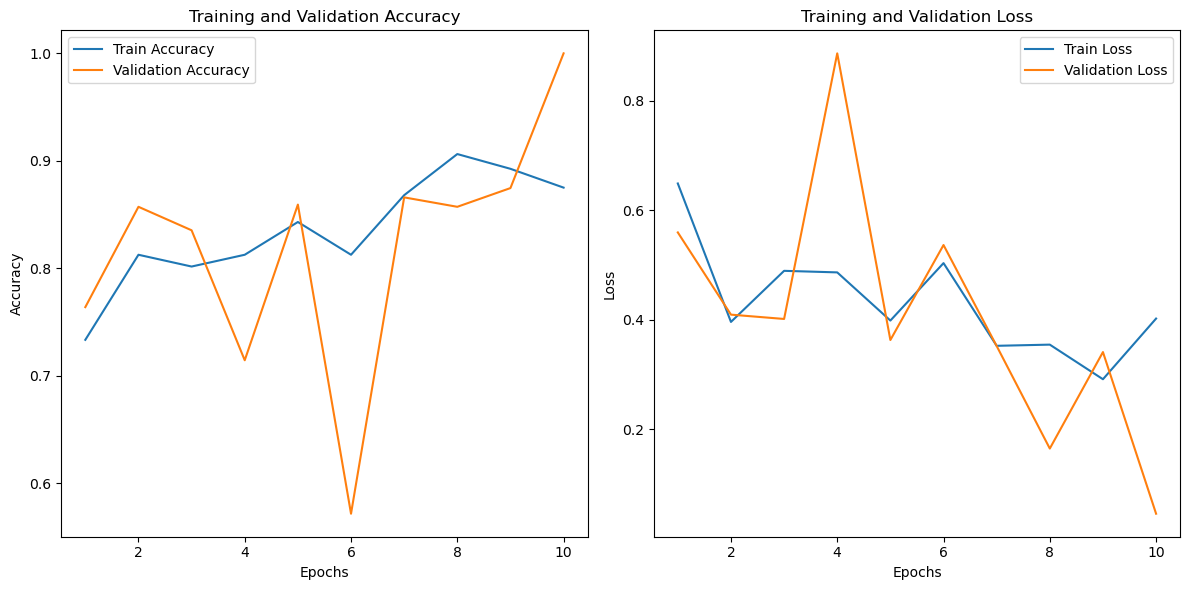

In [36]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Plotting training and validation accuracy
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)  # Create subplot for accuracy
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # Create subplot for loss
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a history object from model training
plot_accuracy_and_loss(history)


##### 3. Model Evaluation for SET2 images

In [37]:
from sklearn.metrics import classification_report
import numpy as np

def generate_classification_report(model, test_generator):
    
    # Reset the test generator
    test_generator.reset()
    
    # Make predictions on the test set using the model
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices
    
    # Get true labels from the test generator
    y_true = test_generator.classes  # Ground truth labels (class indices)
    
    # Get the class indices mapping from the test generator
    class_indices = test_generator.class_indices
    label_map = {v: k for k, v in class_indices.items()}
    
    # Map class indices back to the original labels
    y_true_labels = [label_map[idx] for idx in y_true]
    y_pred_labels = [label_map[idx] for idx in y_pred]
    
    # Generate and print the classification report
    report = classification_report(y_true_labels, y_pred_labels)
    print("Classification Report:\n", report)
    
    return report

# Generate classification report for the test set predictions
generate_classification_report(model, test_generator)


2065/2065 ━━━━━━━━━━━━━━━━━━━━ 462s 224ms/step
Classification Report:
               precision    recall  f1-score   support

       COVID       0.72      0.78      0.75     47379
      NORMAL       0.24      0.18      0.20     15469
   PNEUMONIA       0.05      0.04      0.04      3227

    accuracy                           0.60     66075
   macro avg       0.33      0.33      0.33     66075
weighted avg       0.57      0.60      0.59     66075



'              precision    recall  f1-score   support\n\n       COVID       0.72      0.78      0.75     47379\n      NORMAL       0.24      0.18      0.20     15469\n   PNEUMONIA       0.05      0.04      0.04      3227\n\n    accuracy                           0.60     66075\n   macro avg       0.33      0.33      0.33     66075\nweighted avg       0.57      0.60      0.59     66075\n'

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, test_generator):
    
    # Reset the test generator
    test_generator.reset()
    
    # Make predictions on the test set using the model
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices
    
    # Get true labels from the test generator
    y_true = test_generator.classes  # Ground truth labels (class indices)
    
    # Get the class indices mapping from the test generator
    class_indices = test_generator.class_indices
    label_map = {v: k for k, v in class_indices.items()}
    
    # Map class indices back to the original labels
    y_true_labels = [label_map[idx] for idx in y_true]
    y_pred_labels = [label_map[idx] for idx in y_pred]
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    print(cm)

# Plot confusion matrix for the test set predictions
plot_confusion_matrix(model, test_generator)


2065/2065 ━━━━━━━━━━━━━━━━━━━━ 465s 225ms/step
[[37007  8365  2007]
 [12061  2744   664]
 [ 2489   584   154]]


### SET3 - 20000 images

##### 1. Data Splitting and Training model using CNN of SET3 images

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("Covid19Detection").getOrCreate()
# Load the data into a Spark DataFrame
combined_df = spark.read.csv("/Users/ramyasritellakula/Documents/Covid_19_detection/result/cleaned_data.csv", header=True, inferSchema=True)

# Convert Spark DataFrame to Pandas DataFrame
combined_df_pandas = combined_df.toPandas()

# Split data into features (image paths) and labels
X = combined_df_pandas['image_path']
y = combined_df_pandas['label']

# Sample train data to get exactly 20000 samples
train_sample_size = 20000
train_data = combined_df_pandas.sample(n=train_sample_size, random_state=42)
X_train = train_data['image_path']
y_train = train_data['label']

# Get remaining data for test and validation
remaining_data = combined_df_pandas.drop(train_data.index)

# Split remaining data into test and validation sets (80% test, 20% validation)
X_remaining = remaining_data['image_path']
y_remaining = remaining_data['label']
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.2, random_state=42)

# Print the sizes and label counts
print(f"Size of training set: {len(X_train)} samples")
print(f"Size of validation set: {len(X_val)} samples")
print(f"Size of test set: {len(X_test)} samples")

print("\nLabel counts in training set:")
print(y_train.value_counts())

print("\nLabel counts in validation set:")
print(y_val.value_counts())

print("\nLabel counts in test set:")
print(y_test.value_counts())


# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Create image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for train, test, and validation sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_train, 'label': y_train}),
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_val, 'label': y_val}),
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_test, 'label': y_test}),
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define model checkpoint to save best model during training
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Size of training set: 20000 samples
Size of validation set: 13519 samples
Size of test set: 54075 samples

Label counts in training set:
label
COVID        14329
NORMAL        4639
PNEUMONIA     1032
Name: count, dtype: int64

Label counts in validation set:
label
COVID        9693
NORMAL       3172
PNEUMONIA     654
Name: count, dtype: int64

Label counts in test set:
label
COVID        38838
NORMAL       12650
PNEUMONIA     2587
Name: count, dtype: int64
Found 20000 validated image filenames belonging to 3 classes.
Found 13519 validated image filenames belonging to 3 classes.
Found 54075 validated image filenames belonging to 3 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.7629 - loss: 0.5992
Epoch 1: val_accuracy improved from -inf to 0.86767, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 483s 771ms/step - accuracy: 0.7630 - loss: 0.5990 - val_accuracy: 0.8677 - val_loss: 0.3402
Epoch 2/10

Epoch 2: val_accuracy improved from 0.86767 to 0.93333, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9333 - val_loss: 0.2038
Epoch 3/10


2024-05-05 09:58:09.866633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-05 09:58:09.941621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.8719 - loss: 0.3392
Epoch 3: val_accuracy did not improve from 0.93333
625/625 ━━━━━━━━━━━━━━━━━━━━ 535s 854ms/step - accuracy: 0.8719 - loss: 0.3392 - val_accuracy: 0.8878 - val_loss: 0.3125
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.93333
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 144us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8000 - val_loss: 0.5060
Epoch 5/10


2024-05-05 10:07:04.803967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 10:07:04.888022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.8940 - loss: 0.2789
Epoch 5: val_accuracy did not improve from 0.93333
625/625 ━━━━━━━━━━━━━━━━━━━━ 523s 835ms/step - accuracy: 0.8940 - loss: 0.2789 - val_accuracy: 0.8871 - val_loss: 0.2988
Epoch 6/10

Epoch 6: val_accuracy improved from 0.93333 to 1.00000, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1075
Epoch 7/10


2024-05-05 10:15:47.973697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 10:15:48.054947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.9033 - loss: 0.2593
Epoch 7: val_accuracy did not improve from 1.00000
625/625 ━━━━━━━━━━━━━━━━━━━━ 685s 1s/step - accuracy: 0.9033 - loss: 0.2593 - val_accuracy: 0.8985 - val_loss: 0.2825
Epoch 8/10

Epoch 8: val_accuracy did not improve from 1.00000
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 143us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8667 - val_loss: 0.2073
Epoch 9/10


2024-05-05 10:27:13.537464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 10:27:13.617917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9183 - loss: 0.2231
Epoch 9: val_accuracy did not improve from 1.00000
625/625 ━━━━━━━━━━━━━━━━━━━━ 491s 784ms/step - accuracy: 0.9183 - loss: 0.2231 - val_accuracy: 0.9037 - val_loss: 0.2780
Epoch 10/10

Epoch 10: val_accuracy did not improve from 1.00000
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 141us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8000 - val_loss: 0.5718


2024-05-05 10:35:24.589261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-05 10:35:24.669502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1690/1690 ━━━━━━━━━━━━━━━━━━━━ 435s 257ms/step - accuracy: 0.9019 - loss: 0.2853
Test Loss: 0.2807624936103821
Test Accuracy: 0.9038557410240173


##### 2. Model Evaluation of SET3 images

In [40]:
from sklearn.metrics import classification_report
import numpy as np

def generate_classification_report(model, test_generator):
    
    # Reset the test generator
    test_generator.reset()
    
    # Make predictions on the test set using the model
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices
    
    # Get true labels from the test generator
    y_true = test_generator.classes  # Ground truth labels (class indices)
    
    # Get the class indices mapping from the test generator
    class_indices = test_generator.class_indices
    label_map = {v: k for k, v in class_indices.items()}
    
    # Map class indices back to the original labels
    y_true_labels = [label_map[idx] for idx in y_true]
    y_pred_labels = [label_map[idx] for idx in y_pred]
    
    # Generate and print the classification report
    report = classification_report(y_true_labels, y_pred_labels)
    print("Classification Report:\n", report)
    
    return report

# Generate classification report for the test set predictions
generate_classification_report(model, test_generator)


1690/1690 ━━━━━━━━━━━━━━━━━━━━ 435s 257ms/step
Classification Report:
               precision    recall  f1-score   support

       COVID       0.72      0.78      0.75     38838
      NORMAL       0.24      0.18      0.21     12650
   PNEUMONIA       0.04      0.04      0.04      2587

    accuracy                           0.60     54075
   macro avg       0.34      0.33      0.33     54075
weighted avg       0.58      0.60      0.59     54075



'              precision    recall  f1-score   support\n\n       COVID       0.72      0.78      0.75     38838\n      NORMAL       0.24      0.18      0.21     12650\n   PNEUMONIA       0.04      0.04      0.04      2587\n\n    accuracy                           0.60     54075\n   macro avg       0.34      0.33      0.33     54075\nweighted avg       0.58      0.60      0.59     54075\n'

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, test_generator):
    
    # Reset the test generator
    test_generator.reset()
    
    # Make predictions on the test set using the model
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices
    
    # Get true labels from the test generator
    y_true = test_generator.classes  # Ground truth labels (class indices)
    
    # Get the class indices mapping from the test generator
    class_indices = test_generator.class_indices
    label_map = {v: k for k, v in class_indices.items()}
    
    # Map class indices back to the original labels
    y_true_labels = [label_map[idx] for idx in y_true]
    y_pred_labels = [label_map[idx] for idx in y_pred]
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    print(cm)

# Plot confusion matrix for the test set predictions
plot_confusion_matrix(model, test_generator)


1690/1690 ━━━━━━━━━━━━━━━━━━━━ 364s 215ms/step
[[30261  6690  1887]
 [ 9819  2238   593]
 [ 2029   428   130]]


### After training the model with each set, running the unknown images (Stored in sample folder) through our model and predicting the results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


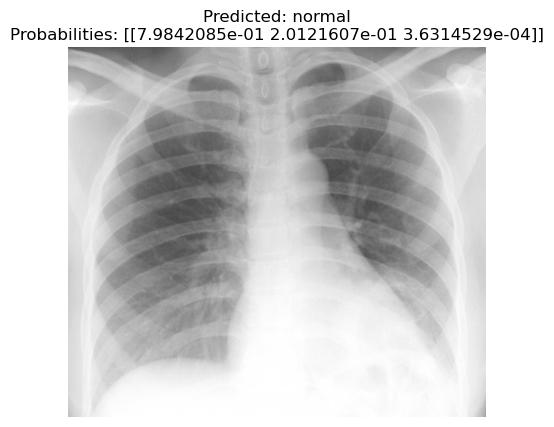

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


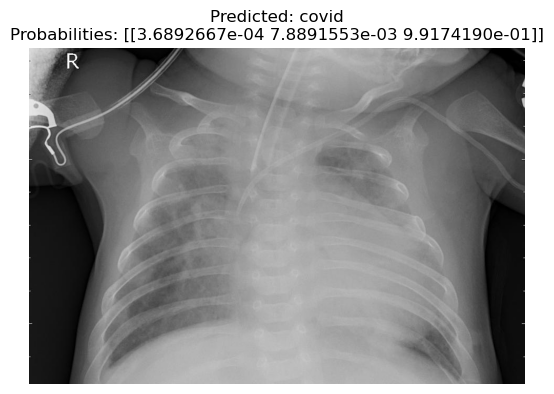

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


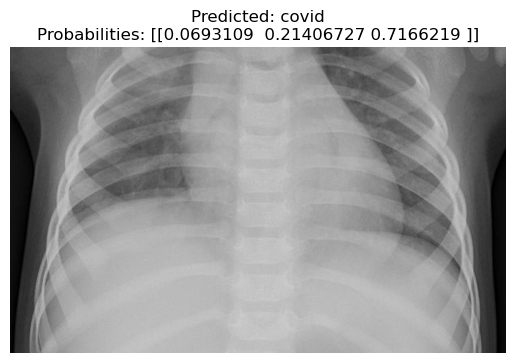

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


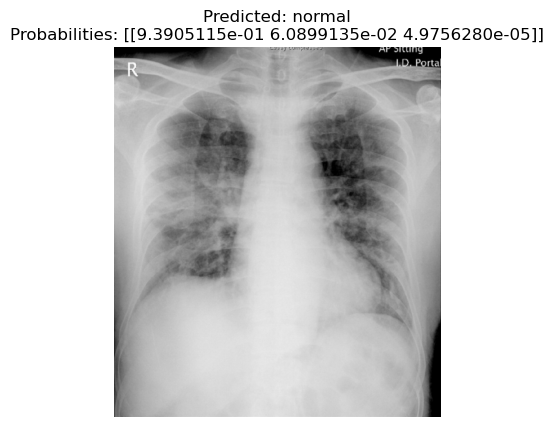

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


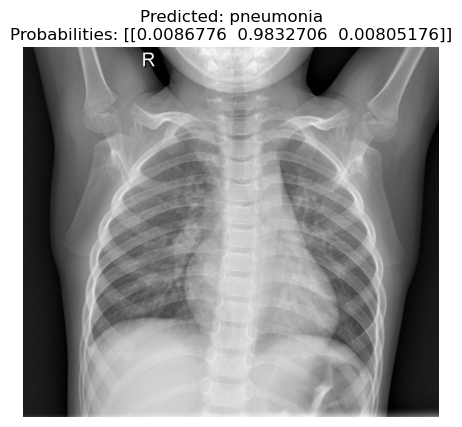

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


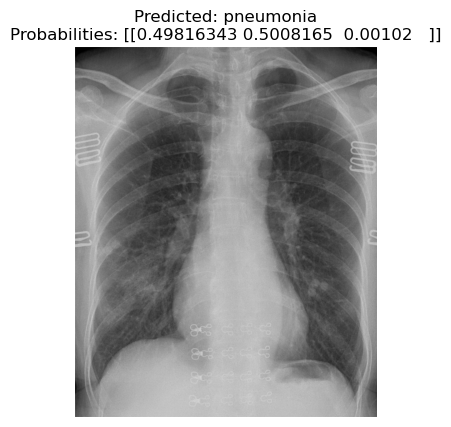

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


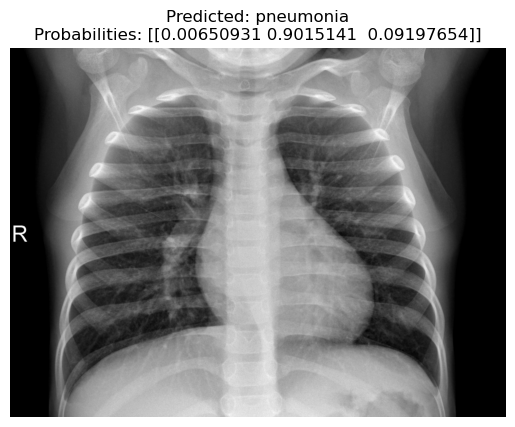

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


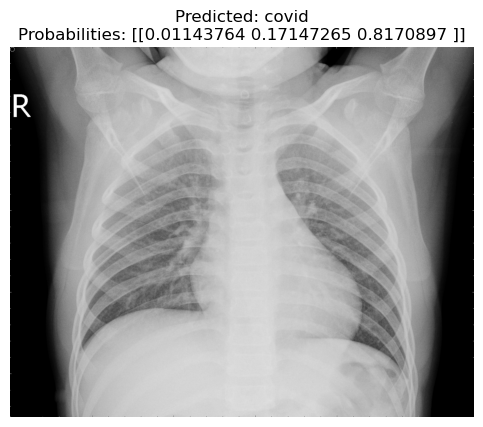

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


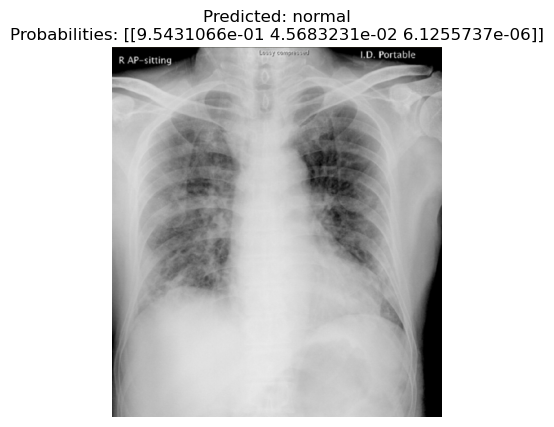

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


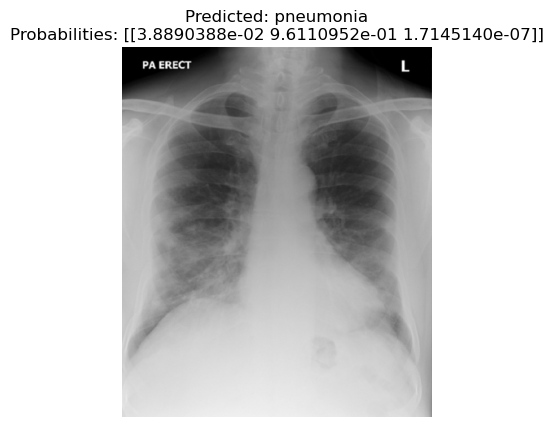

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


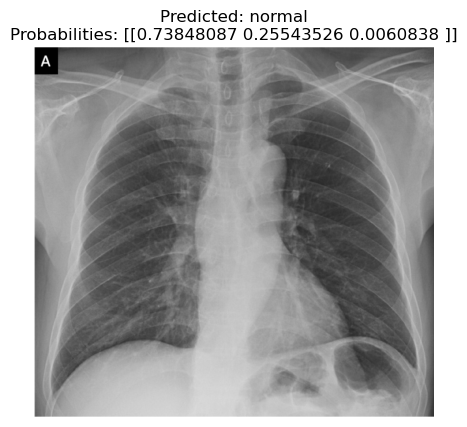

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


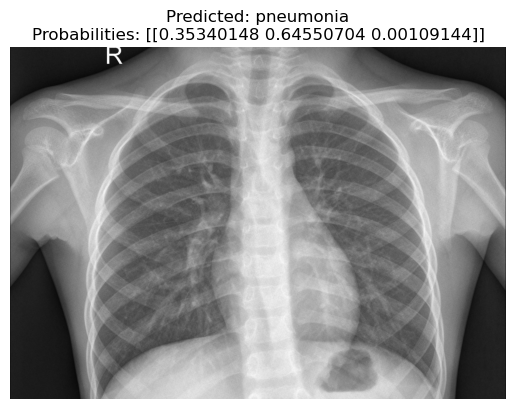

In [42]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained model
model = load_model("best_model.keras")

# Define the image dimensions
img_height, img_width = 224, 224

# Define a function to preprocess an image
def preprocess_image(image_path, img_height, img_width):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    
    # Check if the image was loaded successfully
    if image is None:
        raise FileNotFoundError(f"Could not load image at path: {image_path}")
    
    # Resize the image to the required dimensions
    resized_image = cv2.resize(image, (img_height, img_width))
    
    # Convert the image from BGR (OpenCV format) to RGB (Keras format)
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    
    # Convert the image to a numpy array and normalize pixel values to range [0,1]
    image_array = img_to_array(resized_image) / 255.0
    
    # Expand dimensions to match the input shape of the model (1, img_height, img_width, 3)
    image_array = np.expand_dims(image_array, axis=0)
    
    return image_array

# Define a function to predict the category of an image
def predict_image(image_path):
    # Preprocess the image
    image_array = preprocess_image(image_path, img_height, img_width)
    
    # Predict the class probabilities
    predictions = model.predict(image_array)
    
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)
    
    # Define the classes
    classes = ['normal', 'pneumonia', 'covid']
    
    # Get the predicted class label
    predicted_class = classes[predicted_class_index]
    
    # Return the predicted label and probability distribution
    return predicted_class, predictions

# Define a function to display the prediction for an image
def display_prediction(image_path, predicted_label, prediction_probs):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    
    # Convert the image from BGR (OpenCV format) to RGB (matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')
    
    # Display the predicted label and probabilities as the title
    plt.title(f"Predicted: {predicted_label}\nProbabilities: {prediction_probs}")
    plt.show()

# Path to the directory with the 7 unlabeled images
unlabeled_images_dir = "/Users/ramyasritellakula/Documents/Covid_19_detection/sample"

# Get the list of image file paths in the directory
image_paths = [os.path.join(unlabeled_images_dir, image_name) for image_name in os.listdir(unlabeled_images_dir) if image_name.endswith((".jpg", ".jpeg", ".png"))]

# Predict and display results for each image
for image_path in image_paths:
    # Predict the label and probability distribution of the image
    predicted_label, prediction_probs = predict_image(image_path)
    
    # Display the prediction for the image
    display_prediction(image_path, predicted_label, prediction_probs)


### Predicting Covid-19 Status from Chest X-ray Images

In [46]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model

def predict_from_image(img_path):
    # Load and preprocess the image
    xtest_image = image.load_img(img_path, target_size=(224, 224))
    xtest_image = image.img_to_array(xtest_image)
    xtest_image = np.expand_dims(xtest_image, axis=0)
    
    # Make a prediction using the model
    results = model.predict(xtest_image)
    
    # Load the image using OpenCV
    show = cv2.imread(img_path)
    show = cv2.resize(show, (400, 400))
    
    # Display the image
    plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    # Determine the prediction
    if results[0][0] == 0:
        prediction = 'Positive for Covid-19'
    else:
        prediction = 'Negative for Covid-19'
    
    # Print the prediction
    print("Prediction of our model:", prediction)
    
    # Show the image
    plt.show()



Enter path for chest X-ray image:  /Users/ramyasritellakula/Documents/Covid_19_detection/sample/person1_bacteria_1.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction of our model: Negative for Covid-19


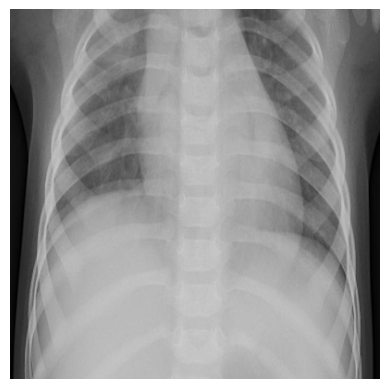

In [47]:
# Ask the user for an image path and make a prediction
image_path = input("Enter path for chest X-ray image: ")
predict_from_image(image_path)


Enter path for chest X-ray image:  /Users/ramyasritellakula/Documents/Covid_19_detection/sample/person1_virus_6.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction of our model: Positive for Covid-19


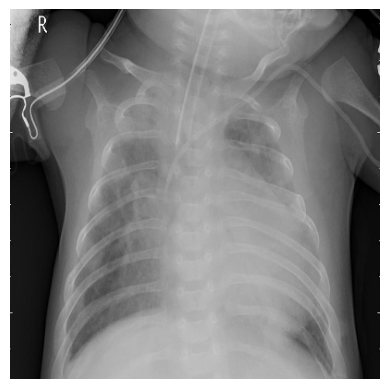

In [48]:
# Ask the user for an image path and make a prediction
image_path = input("Enter path for chest X-ray image: ")
predict_from_image(image_path)


In [31]:
# Stop the Spark session
spark.stop()

### Result Summary

1. SET1 (2000 images): Achieved a test loss of 0.4208 and test accuracy of 83.37%, indicating decent model performance.

2. SET2 (5000 images): Improved results with a test loss of 0.3532 and test accuracy of 87.58%, suggesting the model benefits from a larger dataset.

3. SET3 (20,000 images): Best performance with the largest dataset, achieving a test loss of 0.2808 and test accuracy of 90.39%. This showcases the model's ability to generalize effectively with more data.

4. Larger training datasets enhance model accuracy and reduce loss in Covid-19 detection using CNNs, with a substantial increase in predictive precision as the dataset size increases.

### Conclusion and Observations:

1. Our goal was to use a CNN model to predict the presence of Covid-19, Pneumonia and Normal cases from Chest X-ray images.

2. We trained three models with varying dataset sizes (SET1: 2000 images, SET2: 5000 images, and SET3: 20,000 images) to observe how the model's performance changes with the size of the training data.

3. Improved Performance with Larger Datasets: As the size of the training set increases, there is a clear improvement in the model's performance, reflected in lower test loss and higher test accuracy.

4. The model trained with SET3 (20,000 images) exhibited the best performance with a test accuracy of 90.39% and a lower test loss of 0.2808.